## Install hopsworks

## Imports

In [1]:
!pip uninstall hopsworks hsfs hsml -y

!pip install hopsworks[python]

Found existing installation: hopsworks 4.1.4
Uninstalling hopsworks-4.1.4:
  Successfully uninstalled hopsworks-4.1.4
  Using cached hopsworks-4.1.4-py3-none-any.whl.metadata (11 kB)
Using cached hopsworks-4.1.4-py3-none-any.whl (640 kB)


In [2]:
import os
import requests

from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

#Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, r2_score

import hopsworks
import json
import warnings
warnings.filterwarnings("ignore")

## Read data from Hopsworks

In [3]:
project = hopsworks.login(project="dbillLab1")
fs = project.get_feature_store()

movie_fg = fs.get_feature_group(
    name='tmdb_movies',
    version=1,
)

genres_fg= fs.get_feature_group(
    name='tmdb_movie_genres',
    version=1,
)

selected_features = movie_fg.select(['title','release_date', 'revenue', 'runtime', 'budget',
                                     'original_language', 'imdb_rating',
                                     'production_countries', 'imdb_votes']).join(genres_fg.select_all(), on=['id'])



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1169559


In [4]:
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.47s) 


,title,release_date,revenue,runtime,budget,original_language,imdb_rating,production_countries,imdb_votes,id,...,history,horror,music,mystery,romance,science_fiction,tv_movie,thriller,war,western
0,Moscow Heat,2004-11-24,840201.0,89.0,0.0,en,2.5,Russia,2438.0,106546,...,0,0,0,0,0,0,0,1,0,0
1,A Killing Affair,1977-09-21,0.0,100.0,0.0,en,6.1,United States of America,125.0,5526,...,0,0,0,0,0,0,1,0,0,0
2,Top Secret,1952-11-10,0.0,93.0,0.0,en,6.3,United Kingdom,201.0,194432,...,0,0,0,0,0,0,0,0,0,0
3,The Man Who Could Work Miracles,1936-07-23,0.0,82.0,0.0,en,6.9,United Kingdom,1647.0,68849,...,0,0,0,0,0,0,0,0,0,0
4,Them Who?,2015-11-19,0.0,95.0,0.0,it,6.4,Italy,1910.0,369230,...,0,0,0,0,0,0,0,0,0,0
5,She Freak,1967-05-03,0.0,83.0,0.0,en,3.6,United States of America,1259.0,30935,...,0,1,0,0,0,0,0,0,0,0
6,More Than Meets the Eye: The Joan Brock Story,2003-06-16,0.0,120.0,0.0,en,6.4,Canada,181.0,113192,...,0,0,0,0,0,0,1,0,0,0
7,Five,1951-04-25,0.0,93.0,0.0,en,6.3,United States of America,1693.0,48481,...,0,0,0,0,0,1,0,0,0,0
8,The Manitou,1978-04-28,0.0,104.0,0.0,en,5.4,"Canada, United States of America",3452.0,40060,...,0,1,0,0,0,1,0,0,0,0
9,Cold Feet,1989-05-19,290000.0,94.0,0.0,en,4.8,United States of America,477.0,88658,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Creating a feature view
feature_view = fs.get_or_create_feature_view(
    name='tmdb_fv',
    description="movie features with imdb rating as the target",
    version=1,
    labels=['imdb_rating'],
    query=selected_features,
)

In [6]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.2, random_state=48)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.36s) 


In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Label encoding categorical features

X_train['production_countries'] = label_encoder.fit_transform(X_train['production_countries'])
X_train['original_language'] = label_encoder.fit_transform(X_train['original_language'])

X_test['production_countries'] = label_encoder.fit_transform(X_test['production_countries'])
X_test['original_language'] = label_encoder.fit_transform(X_test['original_language'])

#X_train.head()
print(X_train['production_countries'].unique())
print(X_train['original_language'].unique())

[1092 1260 1206 ...  332 1210  506]
[14 28 22 34 15 58  7 49 11 20 55 29 45 56 10 39 57 44 47 43 61 26  6 13
 67 19 41  8  2 16 33 21  1 24 53 27 59 42 30 62 18  4 17 68 65 35 46 38
 60 64 36 25 23  3 48 63 52  0 66  9 54 37 50 40 32 51 31 12  5]


# Training models
XGBoost, RandomForest, Linear Regression, SVR, DecisionTree

In [8]:
from xgboost import XGBRegressor

xgb_model= XGBRegressor()
rf_model= RandomForestRegressor(random_state=48)
lr_model= LinearRegression()
svr_model= SVR()
dt_model= DecisionTreeRegressor(random_state=48)

models={
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Linear Regression": lr_model,
    "SVR": svr_model,
    "Decision Tree": dt_model
}

## With categorical features
Removed production countries as they could have several values and majority had the U.S

In [9]:
with_cat=['id', 'title','timestamp','release_date', 'production_countries']

train_features= X_train.drop(with_cat, axis=1)
test_features = X_test.drop(with_cat, axis=1)

for name, model in models.items():
    model.fit(train_features, y_train)
    print(name)
    y_pred= model.predict(test_features)
    mse= mean_squared_error(y_test.iloc[:,0], y_pred)
    print("MSE:", mse)
    r2 = r2_score(y_test.iloc[:,0], y_pred)
    print("R squared:", r2)
    print('_________')

XGBoost
MSE: 0.8752873960192634
R squared: 0.32223583446423054
_________
Random Forest
MSE: 0.7532774970489557
R squared: 0.41671216045589854
_________
Linear Regression
MSE: 0.8833159267071172
R squared: 0.3160190759151199
_________
SVR
MSE: 1.2382837305579462
R squared: 0.04115568994248897
_________
Decision Tree
MSE: 1.4639844357976655
R squared: -0.13361187879360448
_________


## Without categorical features
Removed original language as well since half of the dataset had "en" (english). Removing this feature led to a lower MSE.

In [10]:
drop_list=['id', 'title','timestamp','release_date', 'original_language', 'production_countries']

print("Dropped:", drop_list, "\n")
train_features= X_train.drop(drop_list, axis=1)
test_features = X_test.drop(drop_list, axis=1)

for name, model in models.items():
    model.fit(train_features, y_train)
    print(name)
    y_pred= model.predict(test_features)
    mse= mean_squared_error(y_test.iloc[:,0], y_pred)
    print("MSE:", mse)
    r2 = r2_score(y_test.iloc[:,0], y_pred)
    print("R squared:", r2)
    print('_________')
    models[name]= model
    models[name+'_mse']= mse
    models[name+'_r2']= r2

Dropped: ['id', 'title', 'timestamp', 'release_date', 'original_language', 'production_countries'] 

XGBoost
MSE: 0.6810645614155886
R squared: 0.4726290401950878
_________
Random Forest
MSE: 0.7327533192636738
R squared: 0.432604714482397
_________
Linear Regression
MSE: 0.8876971740313109
R squared: 0.31262653027788945
_________
SVR
MSE: 1.2383352469428939
R squared: 0.041115799090850835
_________
Decision Tree
MSE: 1.3584464980544746
R squared: -0.05189034066545184
_________


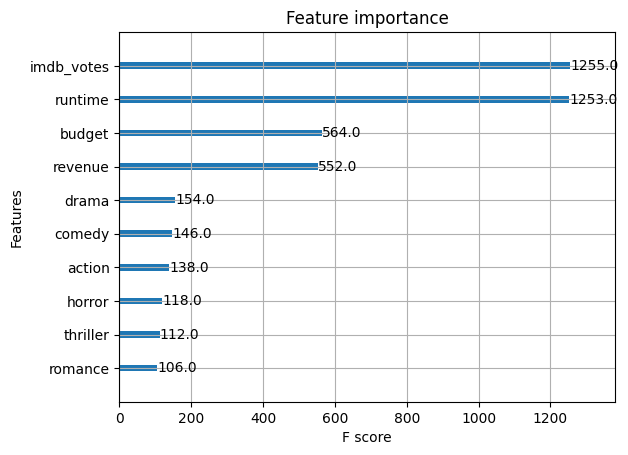

In [11]:
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=10)
plt.show()

In [12]:
model = models['XGBoost']
r2 = models['XGBoost_r2']
mse = models['XGBoost_mse']

In [13]:
# Save the model
import pickle
model_file = 'imdb_rating_model.pkl'

with open(model_file, 'wb') as f:
    pickle.dump(model, f)

In [14]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [15]:
res_dict = {
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [16]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'imdb_rating_model'

movie_rating_pred_model = mr.python.create_model(
    name="movie_rating_xgboost_model",
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values,
    description="Movie Rating (1 to 10) predictor",
)

# Saving the model artifacts to the model registry
movie_rating_pred_model.save(model_file)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/422620 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/160 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2199 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1169559/models/movie_rating_xgboost_model/1


Model(name: 'movie_rating_xgboost_model', version: 1)